In [1]:
import pandas as pd
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer, LancasterStemmer
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from nltk import pos_tag
import numpy as np
np.random.seed(2018)
import nltk
from datetime import datetime
import csv

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sorengran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sorengran/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
stemmer1 = SnowballStemmer('english')
stemmer2 = LancasterStemmer()

In [3]:
'''
code largely appropriated from these websites
visualizations:
https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/

topics modeling:
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

raising errors:
https://docs.python.org/3/tutorial/errors.html
'''

'\ncode largely appropriated from these websites\nvisualizations:\nhttps://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/\n\ntopics modeling:\nhttps://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24\n\nraising errors:\nhttps://docs.python.org/3/tutorial/errors.html\n'

In [4]:
class Error(Exception):
    '''Base class for exceptions in this module.'''
    pass

class InputError(Error):
    '''Exception raised for errors in the input.
    
    Attributes:
        expression -- input expression in which the error occurred
        message -- explanation of the error
    '''
    
    def __init__(self, expression, message):
        self.expression = expression
        self.message = message

In [5]:
class TopicModel():
    
    def __init__(self, filename, search_terms, sort_by = 'year', num_topics=15):
        
        '''
        after these steps, the steps for both file types are the same
            -we stem our search terms
            -we select our relevant columns: abstracts, country, and date.
            -depending on the parameters, we trim 'date' down to Year-Month, just Year, or leave it as Year-Month-Day.
        '''
        
        # let's stem the search terms so they align with our stemmed data
        self.searchterms = search_terms
        self.cleaned_terms = []
        for term in search_terms.split():
            self.cleaned_terms.append(self.stem2(term))
        
        self.sort_by = sort_by
        
        self.data = pd.read_csv(filename)
        
        # select relevant columns
        # we are interested in Abstract DWPI (our main focus of analysis),
        # Assignee - Original - Country/Region (indicates the source country),
        # and Application Date.
        # We use Abstract DWPI instead of just DWPI because it is generally cleaner and more informative.
        self.documents = self.data[['abstract', 'country']]
        
        #  format is DD MMM YYYY but this may be too granular to see trends in the data.
        # If the user specifies sort_by = 'Month', we only care about MMM YYYY so we cut off the DD.
        old_height, _ = self.documents.shape
        if self.sort_by == 'month':
            self.documents['date'] = self.data[['month']]
            self.documents['date'] = pd.to_datetime(self.documents['date'], errors='coerce')
        # If the user specifies sort_by 'Year', we only care about YYYY so we cut off the DD MMM.
        elif self.sort_by == 'year':
                self.documents['date'] = self.data[['year']]
                self.documents['date'] = pd.to_datetime(self.documents['date'], errors='coerce', format='%Y')
        # If the user specifies sort_by = 'Day', we don't need to change anything.
        elif self.sort_by == 'day':
            self.documents['date'] = self.data[['date']]
            self.documents['date'] = pd.to_datetime(self.documents['date'], errors='coerce')
        else:
            raise InputError(self.sort_by, 'sort_by must be set as \'year\', \'month\', or \'day\'.')
        # to_datetime converts the date string to a datetime object, telling the dataframe that 2015-04 comes after 2015-03
        
        
        self.documents['date'] = pd.to_datetime(self.documents['date'])
        # to_datetime only accepts dates from around 1600 to 2200. errors='coerce' makes dates outside this range in NaT values
        
        
        # attribute of unique country codes for user convenience
        self.unique_countries = self.documents['country'].unique()
        
        # we remove the bad values here
        self.documents = self.documents.dropna(subset=['date'])
        new_height, _ = self.documents.shape
        # to make sure we don't remove too many rows (which would indicate a larger problem), we print how many rows we removed
        height_change = old_height - new_height
        print('We removed {0} rows due to bad dates'.format(height_change))
        
        # indexing the documents, creating a simple ID
        length, width = self.documents.shape
        index_column = list(range(length)) # list from 0 to length of dataframe (i.e. number of abstracts)
        self.documents.insert(0, 'index_pos', index_column) # adds this new ID column to the dataframe
        
        # dropping documents with no abstract
        old_height, _ = self.documents.shape
        self.documents['abstract'].replace('', np.nan, inplace=True)
        self.clean_documents = self.documents.dropna(subset=['abstract'])
        new_height, _ = self.clean_documents.shape
        height_change = old_height - new_height
        print('We removed {0} rows due to missing abstracts'.format(height_change))
        
        
        # preprocess the data
        processed_docs = self.clean_documents['abstract'].map(self.preprocess)
        # indexing the words in the corpus
        dictionary = Dictionary(processed_docs)
        # removing extremely rare and common words
        dictionary.filter_extremes(no_below=15, no_above=0.4, keep_n=100000)
        # removes words in fewer than 15 documents or more than 40% of the corpus. Only keeps the first n most frequent words.
        
        # create the model
        # converts documents to bag of words (bow). bow consists of token IDs and their frequency counts for every document.
        bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
        # tf-idf is a measure of word importance, just like frequency count could be considered a measure of importance.
        # However, tf-idf assumes that words that appear in a high percentage of documents are less important, but if they appear frequently in one document, they are more important.
        tfidf = TfidfModel(bow_corpus)
        corpus_tfidf = tfidf[bow_corpus]
        
        # our model using Gensim
        self.lda_model = LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=50, workers=2)
        
        # now we start building the dataframe we will visualize
        # build a key of topics and ids
        topic_words = []
        topic_id = []
        # the topics come in a list format, so this for loop breaks down the list into a string
        for idx, topic in self.lda_model.print_topics(-1):
            words = topic.split('"') # splits
            words = words[1::2]
            topic_words.append(words)
            topic_id.append(idx)
        self.topic_labels = pd.DataFrame(list(zip(topic_id, topic_words)), columns = ['topic_id', 'topic_words'])
        # make the list of topic words into a string
        self.topic_labels['topic_words'] = self.topic_labels['topic_words'].apply(lambda x: str(','.join(x)))
        
        # build a dataframe of how the topics appear in each document
        index_pos = []
        topic_id = []
        topic_weight = []
        count = 0
        for topics in self.lda_model.get_document_topics(bow_corpus):
            for topic in topics:
                index_pos.append(count)
                top_id, top_weight = topic
                topic_id.append(top_id)
                topic_weight.append(top_weight)
            count += 1
        topic_dtm = pd.DataFrame(list(zip(index_pos, topic_id, topic_weight)), columns = ['index_pos', 'topic_id', 'topic_weight'])
        # Normalizing the topic weight dataframe
        # Reorient from long to wide
        dtm = topic_dtm.pivot(index='index_pos', columns='topic_id', values='topic_weight').fillna(0)
        # Divide each value in a row by the sum of the row to normalize the values
        dtm = (dtm.T/dtm.sum(axis=1)).T
        # Shift back to a long dataframe
        dt_norm = dtm.stack().reset_index()
        dt_norm.columns = ['index_pos', 'topic_id', 'norm_topic_weight']
        
        # merging dataframes
        topics_expanded = dt_norm.merge(self.topic_labels, on='topic_id')
        df = topics_expanded.merge(self.clean_documents, on='index_pos', how='left')
        
        # isolating the top topics
        topics = list(self.topic_labels['topic_id'])
        scores = []
        for topic_id in topics:
            # for every topic id, we record its scores
            scores.append(np.mean(df[(df['topic_id'] == topic_id)]['norm_topic_weight']))
        topic_scores = pd.DataFrame(list(zip(topics, scores)), columns=['topic_id', 'scores'])
        self.sorted_topic_scores = topic_scores.sort_values(by=['scores'], ascending = False)
        # sorting the data by date
        self.df = df.sort_values(by=['date'])
    
    
    
    def stem1(self, text):
        '''
        Snowball stemmer used in preprocess()
        Weaker stemmer than Lancaster. Used for stemming corpus.
        '''
        return stemmer1.stem(text)
    
    def stem2(self, text):
        '''
        Lancaster stemmer used in preprocess()
        More aggressive stemmer than Snowball, used to insure search terms do not appear in corpus.
        '''
        return stemmer2.stem(text)
    
    def preprocess(self, text):
        '''
        Preprocessing of data for modeling.
        Tokenizes, removes stopwords and short words, removes puncuation, makes everything lowercase, stems the words, and removes words related to original search terms.
        '''
        result = []
        for token in simple_preprocess(text):
            if token not in STOPWORDS and len(token) > 3:
                stemmed2 = self.stem2(token)
                if stemmed2 not in self.cleaned_terms: # we do not care about our search terms
                    stemmed1 = self.stem1(token)
                    result.append(stemmed1)
        return result
    
    def get_searchterms_xlsx(self, data):
        '''
        returns the original search terms from the patent database
        '''
        terms = []
        searchterms = ['none']
        for item in list(data): # This patent database includes search terms in their top line
            if 'Search results' in str(item):
                searchterms = item
                break
        if searchterms == ['none']:
            return searchterms
        words = searchterms.split('"') # the search terms are in quotations
        words = words[1::2] # after separating by delimiters, we want only every otehr piece
        for word in words:
            individ = words.split(' ') # if two terms were searched together, we want to separate them
            terms = terms + individ
        return terms
    
    def get_searchterms_csv(self, data):
        '''
        returns the original search terms from the patent database
        '''
        str_data = str(data)
        words = str_data.split('"') # the search terms are in quotations
        words = words[1::2] # after separating by delimiters, we want only every otehr piece
        terms = []
        for word in words:
            individ = word.split(' ') # if two terms were searched together, we want to separate them
            terms = terms + individ
        return terms
    
    def line_graph(self, start = None, end = None, country = None, top = 5):
        '''
        This method is the main visualization tool. It visualizes the prominence of the top topics over time based on the norm_topic_weight variable.
        For one year, the y-value of a topic represents that topic's average topic weight for that year, including in abstracts in which it has a weight of zero.
        Parameters
            -start: optional start date for visualization
            -end: optional end date for visualization
            -country: optional country (source of patents) to focus on
            -top: number of top topics to be visualized
        '''
        top_topics = list(self.sorted_topic_scores['topic_id'][0:top]) # gets the top prevalent topics
        # specify order
        sorted_order = []
        graph_df = pd.DataFrame()
        for i in top_topics: # we only want to graph the top topics
            sorted_order.append(self.topic_labels['topic_words'][i])
            current_df = self.df[(self.df['topic_id'] == i)]
            graph_df = pd.concat([graph_df, current_df])
        
        # years, if specified
        if start:
            start = datetime(start, 1, 1)
            graph_df = graph_df[(graph_df['date'] >= start)]
        if end:
            end = datetime(end, 1, 1)
            graph_df = graph_df[(graph_df['date'] < end)]
        # country, if specified
        if country:
            graph_df = graph_df[(graph_df['country'] == country)]
        else:
            country = 'all'
        
        # the following step insures that the x-axis tick labels are legible and show only the specified date
        unique_dates = graph_df['date'].unique()
        x_values = []
        if self.sort_by == 'year':
            for date in unique_dates:
                year = str(date)[:4]
                x_values.append(year)
        elif self.sort_by == 'month':
            for date in unique_dates:
                month = str(date)[:7]
                x_values.append(month)
        else: # self.sort_by == 'day'
            for date in unique_dates:
                day = str(date)[:10]
                x_values.append(day)
        
        # create pointplot
        p = sns.catplot(x='date', y='norm_topic_weight', kind='point', hue_order=sorted_order, hue='topic_words',
                        col=None, col_wrap=None, col_order=sorted_order, height=5, aspect=1.5, data=graph_df, ci=None)
        p.set(xticklabels=x_values)
        for axis in p.axes.flat:
            for item in axis.get_xticklabels():
                item.set_rotation(90) # rotates the x-axis tick labels
        p.fig.subplots_adjust(top=0.9)
        p.fig.suptitle(t='Average Normalized Topic Weights. Search terms: {0}. Country: {1}'.format(self.searchterms, country), fontsize=16)
        return p
    
    def get_abstracts(self, topic_id, start = None, end = None, country = None, top = 5):
        '''
        This method pulls the ten abstracts that are most made up of the chosen topic.
        These abstracts should reflect the topic the best.
        Parameters
            -start: optional start date
            -end: optional end date
            -country: optional country (source of patents)
            -top: number of top topics
        '''
        abstract_df = self.df[(self.df['topic_id'] == topic_id)]
        abstract_df = abstract_df.sort_values(by = ['norm_topic_weight'], ascending = False)
        # years, if specified
        if start:
            start = datetime(start, 1, 1)
            abstract_df = abstract_df[(abstract_df['date'] >= start)]
        if end:
            end = datetime(end, 1, 1)
            abstract_df = abstract_df[(abstract_df['date'] < end)]
        # country, if specified
        if country:
            abstract_df = abstract_df[(abstract_df['country'] == country)]
        for i in range(top):
            print(abstract_df['abstract'].iloc[i])
        return abstract_df[:top]
    
    def get_topicdata(self, start = None, end = None, country = None):
        '''
        This method returns a dataframe of the same data as is graphed in the line_graph().
        In other words, for every topic ID, the dataframe shows for every year that topic ID's average topic weight.
        Parameters
            -start: optional start date
            -end: optional end date
            -country: optional country (source of patents)
            -top: number of top topics
        '''
        topic_df = self.df
        if country:
            topic_df = topic_df[(topic_df['country'] == country)]
        dates = topic_df['date'].unique()
        topic_data = pd.DataFrame()
        topic_data['date'] = dates
        for topic_id in self.topic_labels['topic_id']:
            results = []
            cur_df = topic_df[(topic_df['topic_id'] == topic_id)]
            for date in topic_data['date']:
                date_df = cur_df[(cur_df['date'] == date)]
                result = date_df['norm_topic_weight'].mean()
                results.append(result)
            topic_data['{0}'.format(topic_id)] = results
        if start:
            start = datetime(start, 1, 1)
            topic_data = topic_data[(topic_data['date'] >= start)]
        if end:
            end = datetime(end, 1, 1)
            topic_data = topic_data[(topic_data['date'] < end)]
        return topic_data
    
    def count_graph(self, start = None, end = None, country = None, output = 'graph'):
        '''
        This method returns either a  graph or dataframe of how many patents there were in each year.
        The purpose of this method is to prevent analysts from putting too much weight on outliers, since the prevalence of a topic in one year may be due to the scarty of documents in that year.
        Parameters
            -start: optional start date
            -end: optional end date
            -country: optional country (source of patents)
            -output: 'graph' or 'table'
        '''
        topic_data = self.clean_documents
        if country:
            topic_data = topic_data[(topic_data['country'] == country)]
        if start:
            start = datetime(start, 1, 1)
            topic_data = topic_data[(topic_data['date'] >= start)]
        if end:
            end = datetime(end, 1, 1)
            topic_data = topic_data[(topic_data['date'] < end)]
        
        dates = topic_data['date'].unique()
        count_df = pd.DataFrame()
        count_df['date'] = dates
        counts = []
        for date in count_df['date']:
            current_df = topic_data[(topic_data['date'] == date)]
            count, _ = current_df.shape
            counts.append(count)
        count_df['Counts'] = counts
        
        count_df = count_df.sort_values(by=['date'])
        
        if output == 'graph':
            # the following step insures that the x-axis tick labels are legible and show only the specified date
            unique_dates = count_df['date']
            x_values = []
            if self.sort_by == 'year':
                for date in unique_dates:
                    year = str(date)[:4]
                    x_values.append(int(year))
            elif self.sort_by == 'month':
                for date in unique_dates:
                    month = str(date)[:7]
                    x_values.append(month)
            else: # self.sort_by == 'day'
                for date in unique_dates:
                    day = str(date)[:10]
                    x_values.append(day)
            ax = sns.lineplot(x='date', y='Counts', data=count_df)
            # ax.set(xticklables=x_values)
            for item in ax.get_xticklabels():
                item.set_rotation(90) # rotates the x-axis tick labels
            ax.set_title(label='Count of Documents by Year. Search terms: {0}. Country: {1}'.format(self.searchterms, country))
            return ax
        elif output == 'table':
            return count_df
        else:
            raise InputError(output, 'output must be \'graph\' or \'table\'.')

In [6]:
my_model = TopicModel('Downloads/web_of_science_data.csv', search_terms = 'facial recognition', sort_by = 'year')

<ipython-input-5-1e25329f1fb9>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.documents['date'] = self.data[['year']]
<ipython-input-5-1e25329f1fb9>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.documents['date'] = pd.to_datetime(self.documents['date'], errors='coerce', format='%Y')
<ipython-input-5-1e25329f1fb9>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

We removed 0 rows due to bad dates
We removed 5 rows due to missing abstracts


## Attributes

In [7]:
my_model.data.head()

,Unnamed: 0,abstract,country,date,month,year
0,0,NOVELTY - The system comprises a financial ...,US,15 Nov 2018,Nov 2018,2018
1,1,NOVELTY - The method involves identifying a...,US,20 Nov 2018,Nov 2018,2018
2,2,NOVELTY - The method involves receiving (80...,US,20 Nov 2018,Nov 2018,2018
3,3,NOVELTY - The method involves for retrievin...,US,19 Nov 2018,Nov 2018,2018
4,4,NOVELTY - The method (400) involves assigni...,US,02 Aug 2019,Aug 2019,2019


In [8]:
print(my_model.searchterms)

facial recognition


In [9]:
print(my_model.cleaned_terms)

['fac', 'recognit']


In [10]:
my_model.documents.head()

,index_pos,abstract,country,date
0,0,NOVELTY - The system comprises a financial ...,US,2018-01-01
1,1,NOVELTY - The method involves identifying a...,US,2018-01-01
2,2,NOVELTY - The method involves receiving (80...,US,2018-01-01
3,3,NOVELTY - The method involves for retrievin...,US,2018-01-01
4,4,NOVELTY - The method (400) involves assigni...,US,2019-01-01


In [11]:
print(my_model.unique_countries)

['US' 'CN' 'FR' 'KR' 'WO' 'DE' 'CA' 'PH' 'EP' 'BR' 'TW' 'ES' 'GB' 'JP'
 'IN' 'HK' 'AU' 'RD' 'ZA' 'RU' 'TR' 'SG' 'CH']


In [12]:
my_model.clean_documents.head()

,index_pos,abstract,country,date
0,0,NOVELTY - The system comprises a financial ...,US,2018-01-01
1,1,NOVELTY - The method involves identifying a...,US,2018-01-01
2,2,NOVELTY - The method involves receiving (80...,US,2018-01-01
3,3,NOVELTY - The method involves for retrievin...,US,2018-01-01
4,4,NOVELTY - The method (400) involves assigni...,US,2019-01-01


In [13]:
my_model.topic_labels.head()

,topic_id,topic_words
0,0,"modul,control,connect,collect,termin,identif,l..."
1,1,"heat,rubber,collis,inspect,alter,gate,dissip,p..."
2,2,"cash,custom,skelet,unit,transact,featur,redund..."
3,3,"vehicl,driver,occup,seat,mirror,robot,control,..."
4,4,"fix,plate,bodi,connect,rotat,mount,shell,groov..."


In [14]:
my_model.sorted_topic_scores.head()

,topic_id,scores
7,7,0.366107
10,10,0.337555
4,4,0.155797
0,0,0.088650
8,8,0.018725


In [15]:
my_model.df.head()

,index_pos,topic_id,norm_topic_weight,topic_words,abstract,country,date
18824,1474,5,0.0,"modul,circuit,shell,door,board,connect,infrar,...",The identification circuit uses a sequen...,EP,1990-01-01
50054,1474,14,0.0,"fatigu,water,room,simul,solar,driver,temperatu...",The identification circuit uses a sequen...,EP,1990-01-01
43114,1474,12,0.0,"deploy,window,pedest,laser,conduct,joint,core,...",The identification circuit uses a sequen...,EP,1990-01-01
4944,1474,1,0.0,"heat,rubber,collis,inspect,alter,gate,dissip,p...",The identification circuit uses a sequen...,EP,1990-01-01
39644,1474,11,0.0,"warehous,sell,meter,gender,flash,model,vend,mo...",The identification circuit uses a sequen...,EP,1990-01-01


## Methods

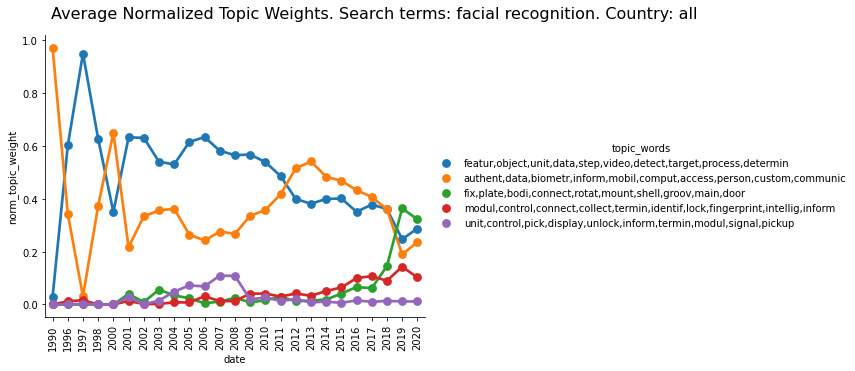

In [16]:
my_model.line_graph()

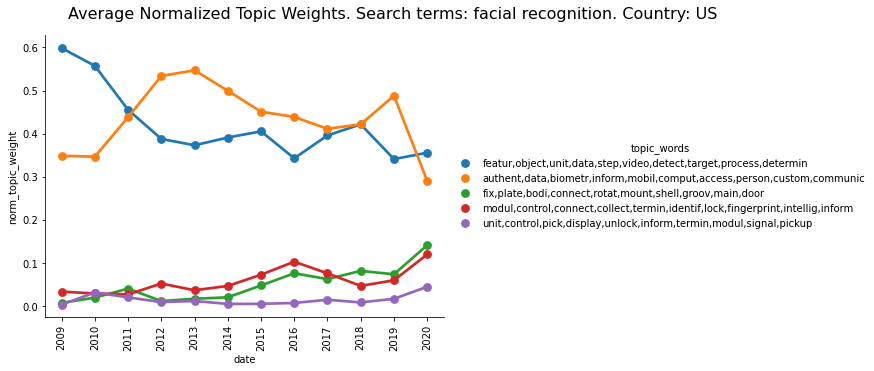

In [17]:
my_model.line_graph(start=2009, country='US')

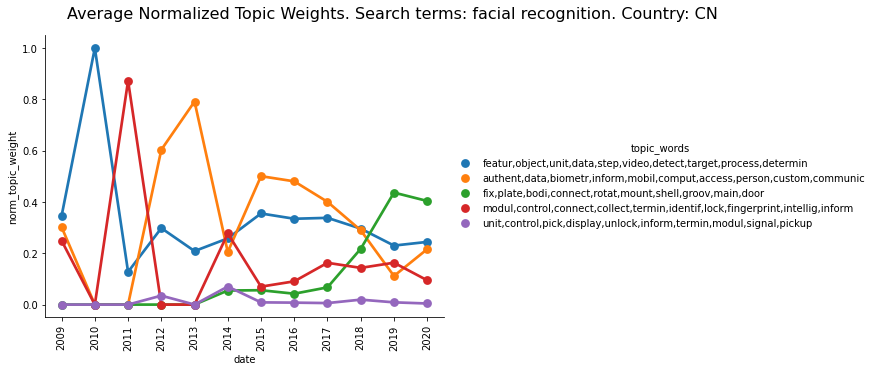

In [18]:
my_model.line_graph(start=2009, country='CN')

In [19]:
my_model.get_abstracts(topic_id=0)

   NOVELTY - The terminal has a control system provided with a processor (1), an identification information collecting module (2), a memory module (3), a display module (4), an operation module (5), an identity identification module (6), an alarm module (7), a monitoring module (8), a self-protecting module (9) and a certificate reading module (10). The identification information collecting module, the storage module, the display module, the operation module, the identity identification module, the alarm module, the monitoring module, the self-protecting module and the certificate reading module are electrically connected with the processor. The operation module is provided with an input unit and a print unit. The identity identification module is provided with a fingerprint identification unit, a facial recognition unit and a voice recognition unit.    USE - Multiple identity authentication based convenience service terminal.    ADVANTAGE - The terminal reduces the problem that non-pr

,index_pos,topic_id,norm_topic_weight,topic_words,abstract,country,date
909,909,0,1.0,"modul,control,connect,collect,termin,identif,l...",NOVELTY - The terminal has a control system...,CN,2018-01-01
855,855,0,1.0,"modul,control,connect,collect,termin,identif,l...",NOVELTY - The system has an infrared sensin...,CN,2017-01-01
417,417,0,1.0,"modul,control,connect,collect,termin,identif,l...",NOVELTY - The utility model claims a facial...,CN,2019-01-01
3275,3275,0,1.0,"modul,control,connect,collect,termin,identif,l...",NOVELTY - The utility model claims a facial...,CN,2019-01-01
753,753,0,1.0,"modul,control,connect,collect,termin,identif,l...",NOVELTY - The structure has a face model to...,CN,2019-01-01


In [20]:
topic_data = my_model.get_topicdata()
topic_data.head()

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1990-01-01,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.029316,0.000000,0.0,0.970684,0.0,0.0,0.0,0.0
1,1996-01-01,0.011921,0.0,0.0,0.043248,0.0,0.0,0.0,0.601562,0.000000,0.0,0.343269,0.0,0.0,0.0,0.0
2,1997-01-01,0.016467,0.0,0.0,0.000000,0.0,0.0,0.0,0.949477,0.003369,0.0,0.030687,0.0,0.0,0.0,0.0
3,1998-01-01,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.626458,0.000000,0.0,0.373542,0.0,0.0,0.0,0.0
4,2000-01-01,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.349993,0.000000,0.0,0.650007,0.0,0.0,0.0,0.0


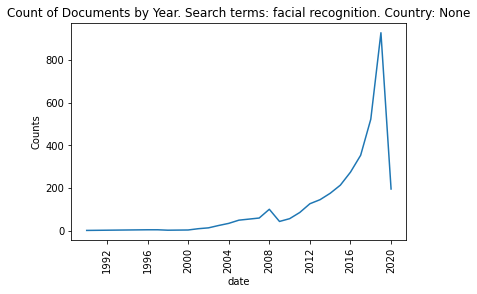

In [21]:
my_model.count_graph()

In [22]:
count_table = my_model.count_graph(output='table')
count_table.head()

,date,Counts
24,1990-01-01,1
21,1996-01-01,4
23,1997-01-01,4
22,1998-01-01,2
19,2000-01-01,3


08/06/19

Creator: Soren Gran

My website: sorengran.com

Please contact me there if you have any questions or concerns about this code.

Good luck!